In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from imageio import imread
import pickle
import tensorflow as tf
from PIL import Image, ImageDraw

from src.data import augment_data, jitter, flip_lr, create_mask

In [2]:
img = imread('/home/ben/Workspace/embc_2020_auto/data/external/i000qa-fn.jpg')
coords = np.loadtxt('/home/ben/Workspace/embc_2020_auto/data/external/i000qa-fn.txt')

with open('/home/ben/Workspace/embc_2020_auto/data/muct/muct_noses.pkl', 'rb') as _f:
    boxes = pickle.load(_f)

In [3]:
rect = list(boxes['i000qa-fn.jpg'])
# rect[0] /= img.shape[1]
# rect[1] /= img.shape[0]
# rect[2] /= img.shape[1]
# rect[3] /= img.shape[0]

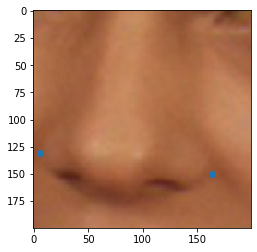

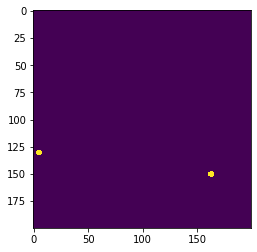

In [57]:
x, y = augment_data(img, coords, rect, size=200, jit_rate=5)
mask = create_mask(y, x.shape[0], x.shape[1])

plt.imshow(x.astype(np.uint8))
plt.scatter(y[:,0], y[:,1])
plt.figure()
plt.imshow(mask)

In [119]:
def jitter(x, y, bbox, jit_rate=5, size=100, seed=0):

    box_width = bbox[2] - bbox[0]
    box_height = bbox[3] - bbox[1]

    offset = np.random.randint(-jit_rate, jit_rate, 2)

    new_bbox = np.zeros(4)

    new_bbox[:2] = bbox[:2] - offset
    new_bbox[2] = new_bbox[0] + box_width
    new_bbox[3] = new_bbox[1] + box_height

    y_crop = y - new_bbox[:2]
    
    resize_ratio = size / box_width
    

    img = Image.fromarray(x)
    img = img.crop(new_bbox).resize((size, size))
    
    mu_crop = y_crop.mean(axis=0)
    y_crop -= mu_crop
    y_crop *= resize_ratio
    y_crop += (mu_crop * resize_ratio)

    return img, y_crop

In [4]:
img = np.array([img, img, img])
coords = np.array([coords, coords, coords])
rect = np.array([rect, rect, rect], dtype=np.float32)

In [5]:
img = tf.convert_to_tensor(img, dtype=tf.float32)
coords = tf.convert_to_tensor(coords, dtype=tf.float32)
rect = tf.convert_to_tensor(rect, dtype=tf.float32)

x, y = img, coords

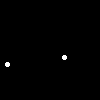

In [128]:
def create_mask(x, y, radius=2):
    
    mask = Image.new("L", (x.shape[0], x.shape[1]))
    draw = ImageDraw.Draw(mask)
    
    for _y in y:
        
        draw.ellipse(
            [
                _y[0] - radius, _y[1] - radius,
                _y[0] + radius, _y[1] + radius
            ],
            fill='white',
            outline='white'
        )
        
    return mask
        
create_mask(x_crop[0], y_crop[0])

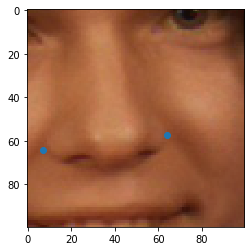

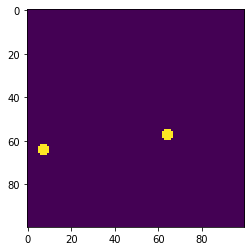

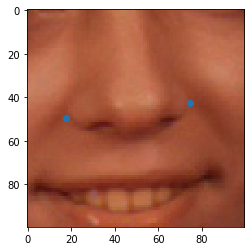

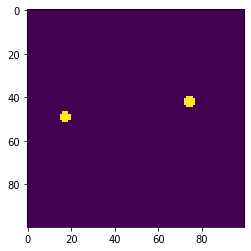

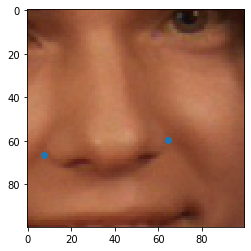

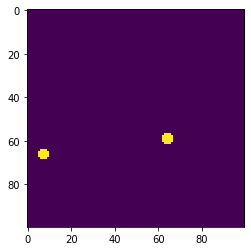

In [124]:
x_crop, y_crop = augment_data(img, coords, rect, size=100, jit_rate=10)

x_crop = x_crop.numpy() * 255
y_crop = y_crop.numpy()
y_crop = y_crop.reshape((-1, 2, 2))
for i in range(3):
    plt.figure()
    plt.imshow(x_crop[i].astype(np.uint8))
    plt.scatter(y_crop[i,:,0], y_crop[i,:,1])
    mask = create_mask(x_crop[i], y_crop[i])
    plt.figure()
    plt.imshow(mask)

In [90]:
mask = np.zeros(x.shape[1:-1])
mask.shape

(640, 480)

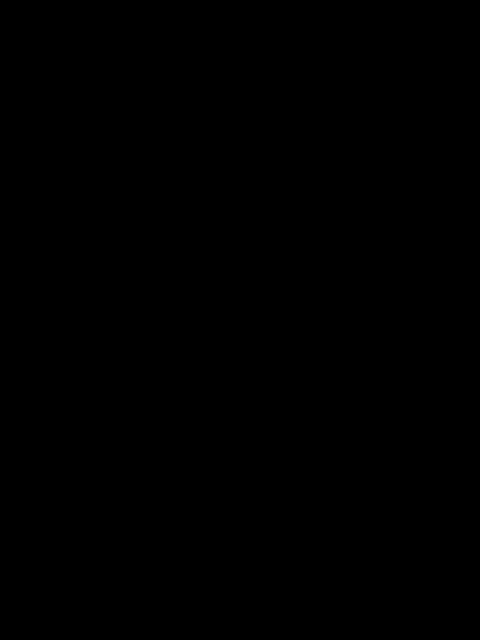

In [94]:
Image.fromarray(mask, mode="L")

In [78]:
mask[16:20, 51:55] = 1

In [89]:
create_mask(x_crop[0],y_crop[0])

IndexError: tuple index out of range

In [6]:
def flip_lr(x, y, rate=0.5, seed=10):
    
    if tf.random.uniform(shape=[], seed=seed) > rate:

        x_lr = tf.image.flip_left_right(x)
        _y = -1 * (y[:,0] - tf.cast(tf.shape(x)[1], tf.float32))
        y_lr = tf.stack((tf.transpose(_y), tf.transpose(y[:,1])), axis=1)

        return x_lr, y_lr
    else:
        return x, y

In [10]:
i = tf.constant(0)
batch_size = tf.shape(x)[0]

while_condition = lambda i: tf.less(i, batch_size)
x_flip = tf.Variable(
    tf.zeros(tf.shape(x),
             dtype=tf.float32))
y_flip = tf.Variable(
    tf.zeros(tf.shape(y), dtype=tf.float32)
)

def _flip(i):

    _x, _y = flip_lr(x[i], y[i], 0.5, 0)
    x_flip[i].assign(_x)
    y_flip[i].assign(_y)
    return [tf.add(i, 1)]
            
tf.while_loop(while_condition, _flip, [i])            

[<tf.Tensor: shape=(), dtype=int32, numpy=3>]

In [11]:
x_lr = x_flip.numpy()
x_lr = x_lr.astype(np.uint8)

y_lr = y_flip.numpy()

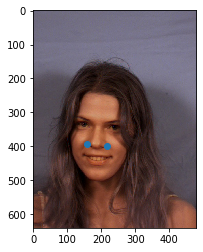

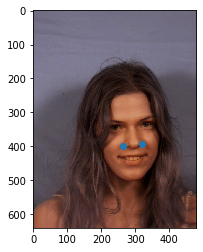

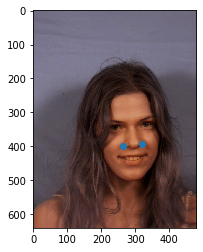

In [12]:
for i in range(3):
    plt.figure()
    plt.imshow(x_lr[i])
    plt.scatter(y_lr[i,:,0], y_lr[i,:,1])

In [ ]:
def jitter(x, y, bbox, jitter=30, size=100):
    
    batch_size = tf.shape(x)[0]
    channels = tf.shape(x)[-1]
    
    offset = tf.random.uniform(shape=[batch_size, 2], minval=-jitter, maxval=jitter, dtype=tf.float32)
    new_bbox = bbox - offset
    new_bbox = tf.reshape(tf.keras.backend.repeat_elements(new_bbox, 2, 0), (batch_size, 2, 2))
    
    y_crop = y - new_bbox
    
    new_bbox = tf.cast(new_bbox, tf.int32)
    
    i = tf.constant(0)
    while_condition = lambda i: tf.less(i, batch_size)
    
    x_crop = tf.Variable(tf.zeros([batch_size, size, size, channels],
                      dtype=tf.float32))
    
    def crop(i):
        print(new_bbox[i])
        _x = tf.image.crop_to_bounding_box(
            x[i],
            offset_height=new_bbox[i][0][1],
            offset_width=new_bbox[i][0][0],
            target_width=size,
            target_height=size,        
        )
        x_crop[i].assign(_x)
        return [tf.add(i, 1)]
    
    tf.while_loop(while_condition, crop, [i])
    
    return x_crop, y_crop

In [ ]:
x_crop, y_crop = augment_data(img, coords, rect)

In [ ]:
i = tf.constant(0)

In [ ]:
tf.image.crop_to_bounding_box(
    x[i],
    offset_height=bbox[i][1],
    offset_width=bbox[i][1],
    target_width=100,
    target_height=100)

In [ ]:
img_crop, y_crop = jitter(img, coords, rect)
# img_crop = tf.image.random_brightness(img_crop, 0.2)

plt.imshow(img_crop.numpy().astype(np.uint8));
plt_np = y_crop.numpy();
plt.scatter(plt_np[:,0], plt_np[:,1]);

In [ ]:
def adjust_image(x):
    
    x_adjust = tf.image.random_brightness(x, 0.5)
    x_adjust = tf.image.random_contrast(x_adjust, 
                                        lower=0.4, upper=1)
    x_adjust = tf.image.random_hue(x_adjust, 0.1)
    x_adjust = tf.image.random_saturation(
        x_adjust, 0.5, 1.5)
    
    return x_adjust

In [ ]:
img_crop, y_crop = jitter(img, coords, rect)

# img_crop = tf.image.adjust_saturation(img_crop, 1.5)

In [ ]:
img_crop = tf.image.adjust_jpeg_quality(img_crop, 50)

In [ ]:
plt.imshow(img_crop.numpy().astype(np.uint8))

In [ ]:
plt.imshow(adjust_image(img_crop).numpy().astype(np.uint8))

In [ ]:
img_crop.numpy() - img_crop_org

In [ ]:
x = tf.image.adjust_brightness(x, delta=1)
plt.imshow(x.numpy().astype(np.uint8))

In [ ]:
plt.imshow(tf.image.adjust_saturation(img_crop, 0.7).numpy().astype(np.uint8))

In [ ]:
plt.imshow(tf.image.adjust_hue(img_crop, 1.02).numpy().astype(np.uint8))

In [ ]:
offset = tf.random.uniform(shape=[2], minval=-20, maxval=20, dtype=tf.int32)
offset

In [ ]:
new_rect = rect - offset

In [ ]:
offset = tf.broadcast_to(tf.cast(new_rect, dtype=tf.float32), [2, 2])
coords = coords - offset
coords

In [ ]:
img_crop = tf.image.crop_to_bounding_box(
    img,
    offset_height=new_rect[1],
    offset_width=new_rect[0],
    target_width=75,
    target_height=75,        
)

plt.imshow(img_crop.numpy().astype(np.uint8));
plt_np = coords.numpy();
plt.scatter(plt_np[:,0], plt_np[:,1]);

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 7))
ax.imshow(img);
ax.scatter(coords[:,0], coords[:,1]);
# ax.scatter(coords[39,0], coords[39,1]);
# ax.scatter(coords[43,0], coords[43,1]);

bbox = patches.Rectangle(
    rect[0,:],
    rect[1,0] - rect[0,0],
    rect[1,1] - rect[0,1],linewidth=1,edgecolor='r',facecolor='none')

ax.add_patch(bbox);

In [ ]:
np.random.randint(20, size=(2,))

In [ ]:
_rect = rect[0,:] - np.random.randint(low=-20, high=20, size=(2,))